In [1]:

# 필요한 라이브러리를 아래 예시처럼 불러옵니다.
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# from scipy.stats import skew

c:\Users\shj82\anaconda3\envs\coin\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
org_idx = 1
org_df = pd.read_csv(f"./contest_data/org_{org_idx}.csv")
# org_df =  pd.read_csv(f"/mnt/elice/dataset/contest_data/org_{org_idx}.csv")

def load_file(org_idx):
    return pd.read_csv(f"./contest_data/org_{org_idx}.csv")

def load_files():
    df_list = []
    for i in range(15):
        df_list.append(load_file(i+1))
    return df_list

def predict(df):
    predicted = df['Close'][-1:-11:-1]
    return list(predicted)


In [6]:
# result.csv로 저장할 결과를 result_df라는 dataframe으로 만들어서 저장하는 예시
result_df = pd.DataFrame(
    columns=[f"org_{org_idx}" for org_idx in range(1, 16)], # org는 총 15개
    index=[f"day{day_idx}" for day_idx in range(1, 11)] # 예측 날짜는 총 10개
)

df_list = load_files()

# 각 org 별로 10일간 예측 결과를 result_df에 저장
for i in range(15):
    result_df['org_{}'.format(i+1)] = predict(df_list[i])

# result_df를 results_csv로 저장
result_df.to_csv("result.csv")

# display(result_df)

temp=df_list[0].Close
temp=temp.iloc[-10:]
print(temp)

2254    0.668488
2255    0.671869
2256    0.655650
2257    0.632227
2258    0.601934
2259    0.589238
2260    0.635360
2261    0.628982
2262    0.632841
2263    0.629439
Name: Close, dtype: float64


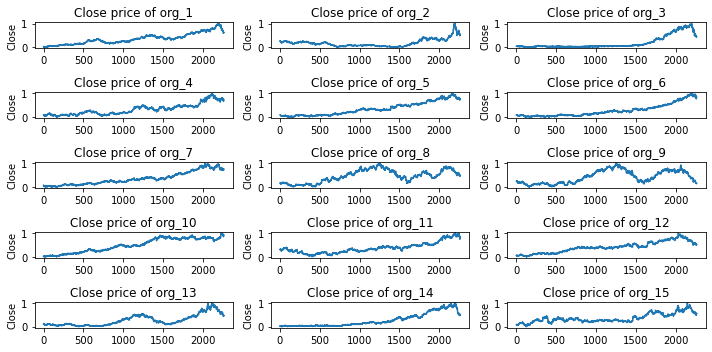

In [16]:
import re
csv_file_names = [_ for _ in os.listdir('./contest_data')]
csv_file_names = sorted(csv_file_names, key=lambda s: int(re.search(r'\d+', s).group()))

company_list = []
for i in range(len(csv_file_names)):
    dataset_filepath = './contest_data/' + csv_file_names[i]
    company_df = pd.read_csv(dataset_filepath, parse_dates=True)
    company_name = dataset_filepath.rsplit('/')[-1].rsplit('.')[0]
    company_df['Company_name'] = company_name
    company_list.append(company_name)
    if i==0:
        df = company_df
    else:
        df = pd.concat([df,company_df],axis=0)

subplot_size = len(company_list)//3
plt.figure(figsize=(10,5))
for i, company in enumerate(company_list, 1):
    plt.subplot(subplot_size,3,i)
    df.loc[df.Company_name==company, 'Close'].plot()
    plt.ylabel('Close'); plt.xlabel(None)
    plt.title("Close price of {}".format(company))
plt.tight_layout()

In [79]:

temp=df_list[0].Close
delta = temp.diff(periods=1)

ups, downs =delta.copy(), delta.copy()
ups[ups < 0] = 0
downs[downs > 0] = 0

#14일치 지수 이동 평균 (EMA, Exponential Moving Average)
periods = 14
au = ups.ewm(com=periods-1, min_periods=periods).mean()
ad = downs.abs().ewm(com=periods-1, min_periods=periods).mean()
# print(temp.tail())
# print(ups.tail())
# print(downs.tail())
print(au.tail())
print(ad.tail())
RS = au/ad
print(RS.tail())
RSI =(100-(100/(1+RS)))
RSI = RSI.dropna()
# print((RSI.tail()))
# a=pd.Series([50])
# RSI=RSI.append(a,ignore_index=False)
# print((RSI.tail()))

2259    0.003641
2260    0.006675
2261    0.006198
2262    0.006031
2263    0.005601
Name: Close, dtype: float64
2259    0.013139
2260    0.012200
2261    0.011784
2262    0.010943
2263    0.010404
Name: Close, dtype: float64
2259    0.277109
2260    0.547137
2261    0.525986
2262    0.551173
2263    0.538300
Name: Close, dtype: float64


학습 횟수 : 0
학습 횟수 : 100


(array([[-2.6776972e+32]]),
 array([[-1.31095262e-13]]),
 array([[-8.67554409e-17]]),
 array([[-5.10855507e-20]]))

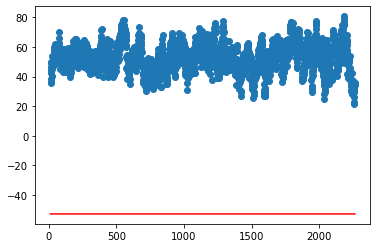

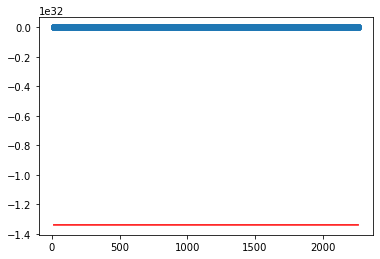

In [26]:
idx=np.array(RSI.index)
idx=idx.reshape(-1,1)
val=np.array(RSI.values)
val=val.reshape(-1,1)
# idx_poly=[]
# # print(idx)
# for x_i in idx:
#     idx_poly.append([
#         x_i[0]**3,
#         x_i[0]**2,
#         x_i[0]
#     ])
# # print(idx_poly)
# lrmodel = LinearRegression()
# lrmodel.fit(idx_poly, val)
# predicted_val_train = lrmodel.predict(idx_poly)
# mse_train = mean_squared_error(val, predicted_val_train)
# print(mse_train)

def plotting_graph(X,y,beta_0,beta_1,beta_2,beta_3):
    
    y_pred = beta_0 + beta_1*X +beta_2*(X**2)+beta_3*(X**3)
    
    fig = plt.figure()
    
    plt.scatter(X, y)
    plt.plot(X, y_pred, c='r')

def poly(X,degree=3):
    model=PolynomialFeatures(degree=degree, include_bias=True)
    x_poly = model.fit_transform(X)
    return x_poly

def prediction(beta_0, beta_1, beta_2, beta_3, X):
    
    y_pred = beta_0 + beta_1*X +beta_2*(X**2)+beta_3*(X**3)
    
    return y_pred

def update_beta(X, y, y_pred, lr, MAE):
    
    delta_0 = -MAE
    
    delta_1 = -(lr * (2 / len(X)) / (np.dot(X.T, (y - y_pred))))
    delta_2 = -(lr * (2 / len(X)) / (np.dot((X**2).T, (y - y_pred))))
    delta_3 = -(lr * (2 / len(X)) / (np.dot((X**3).T, (y - y_pred))))
    
    return delta_0, delta_1, delta_2, delta_3
    

def gradient_descent(X, y, iters, lr):
        
    beta_0 = np.zeros((1,1))
    beta_1 = np.zeros((1,1))
    beta_2 = np.zeros((1,1))
    beta_3 = np.zeros((1,1))
    
    for i in range(iters):
        
        y_pred = prediction(beta_0, beta_1, beta_2, beta_3, X)
        # y_pred = poly(X)
        # print(y_pred)
        # loss = np.mean(np.square(y - y_pred))
        MAE = np.abs(np.subtract(y, y_pred)).mean()
        # print(MAE)
        
        beta0_delta, beta1_delta, beta2_delta, beta3_delta = update_beta(X, y, y_pred, lr, MAE)
        beta_0 += beta0_delta
        beta_1 += beta1_delta
        beta_2 += beta2_delta
        beta_3 += beta3_delta
        
        # 100번의 학습마다 그래프 출력하기
        if i%100==0:
            print("학습 횟수 :",i)
            plotting_graph(X,y,beta_0,beta_1,beta_2,beta_3)
        
    return beta_0, beta_1, beta_2, beta_3


lr = 1e-2
iteration = 10001

iteration = 102

gradient_descent(idx, val, iteration, lr)


# beta_0=lrmodel.coef_
# beta_1=lrmodel.intercept_

          org_1     org_2     org_3     org_4     org_5     org_6     org_7  \
day1   0.623539  0.435395  0.450105  0.709975  0.745579  0.785676  0.734646   
day2   0.622564  0.408884  0.451245  0.707042  0.739992  0.770739  0.735524   
day3   0.622098  0.380056  0.453027  0.704215  0.733972  0.754789  0.736594   
day4   0.622157  0.348821  0.455470  0.701506  0.727504  0.737795  0.737862   
day5   0.622757  0.315093  0.458596  0.698933  0.720571  0.719727  0.739337   
day6   0.623915  0.278785  0.462422  0.696509  0.713157  0.700553  0.741025   
day7   0.625648  0.239809  0.466968  0.694249  0.705247  0.680243  0.742936   
day8   0.627972  0.198078  0.472255  0.692169  0.696823  0.658767  0.745074   
day9   0.630903  0.153505  0.478302  0.690282  0.687870  0.636092  0.747450   
day10  0.634458  0.106002  0.485128  0.688605  0.678372  0.612189  0.750069   

          org_8     org_9    org_10    org_11    org_12    org_13    org_14  \
day1   0.446133  0.096476  0.874039  0.750631  0.50

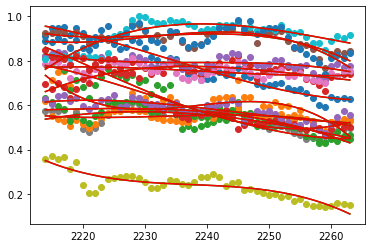

In [23]:
def load_file(org_idx):
    return pd.read_csv(f"./contest_data/org_{org_idx}.csv")

def load_files():
    df_list = []
    for i in range(15):
        df_list.append(load_file(i+1))
    return df_list

result_df = pd.DataFrame(
    columns=[f"org_{org_idx}" for org_idx in range(1, 16)], # org는 총 15개
    index=[f"day{day_idx}" for day_idx in range(1, 11)] # 예측 날짜는 총 10개
)

df_list = load_files()

for i in range(len(df_list)):
    temp=df_list[i].Close
    temp=temp.iloc[-50:]
    idx=np.array(temp.index)
    idx=idx.reshape(-1,1)
    val=np.array(temp.values)
    idx_poly=[]
    for x_i in idx:
        idx_poly.append([
            x_i[0]**3,
            x_i[0]**2,
            x_i[0]
        ])
    idx_poly=np.array(idx_poly)
    
    lrmodel=LinearRegression()
    lrmodel.fit(idx_poly, val)
    predicted = lrmodel.predict(idx_poly)
    model_score = lrmodel.score(idx_poly, val)

    beta_0 = lrmodel.coef_[0] # 3차
    beta_1 = lrmodel.coef_[1] # 2차
    beta_2 = lrmodel.coef_[2] # 1차
    beta_3 = lrmodel.intercept_

    plt.scatter(idx,val)
    plt.plot(idx,(predicted), '-',c='g' )
    plt.plot(idx,(beta_0*idx**3 + beta_1*idx**2 + beta_2*idx + beta_3), c='r')
    # MAE = np.abs(np.subtract(val, val_predicted)).mean()
    # beta0_delta, beta1_delta, beta2_delta, beta3_delta = update_beta(X, y, y_pred, lr, MAE)
    
    result_value=[]
    for ii in range(len(df_list[i]),len(df_list[i])+10):
        result_value.append(beta_0*(ii**3) + beta_1*(ii**2) + beta_2*(ii) + beta_3)

    result_df['org_{}'.format(i+1)] = result_value

print(result_df)
    
# x_train, x_test, y_train, y_test = train_test_split(idx_poly, val, test_size=0.2, random_state=0)
# lrmodel.fit(x_train, y_train)
# predicted_y_train = lrmodel.predict(x_train)
# mse_train = mean_squared_error(y_train, predicted_y_train)
# print("MSE on train data: {}".format(mse_train))
# predicted_y_test = lrmodel.predict(x_test)
# mse_test = mean_squared_error(y_test, predicted_y_test)
# print("MSE on test data: {}".format(mse_test))

In [19]:
print(temp.iloc[-1])
plt.plot(RSI.index, RSI.values)
print(len(df_list))

0.5560411261576814


NameError: name 'RSI' is not defined

In [ ]:
import os

os.system('elice_grade result.csv')